## Writing outputs to Azure Blob Storage

Azure provide [many options](https://azure.microsoft.com/en-us/product-categories/storage/) for storing data. For cloud-native workflows favored by the Planetary Computer, [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-blobs-introduction) is a good choice. In this example we'll compute NDVI for a single image and write the results to a container in Azure Blob Storage as a single-band COG. Note that your storage and compute should be located in the same [Azure region](https://azure.microsoft.com/en-us/global-infrastructure/geographies/). The Planetary Computer Hub and data reside in the West Europe region.

### Compute NDVI

We need something to write. To simulate a workload, let's load in a single [NAIP image](https://planetarycomputer.microsoft.com/dataset/naip#Example-Notebook) from the Planetary Computer's data catalog using [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html) and compute the NDVI using [xrspatial](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.ndvi.html).

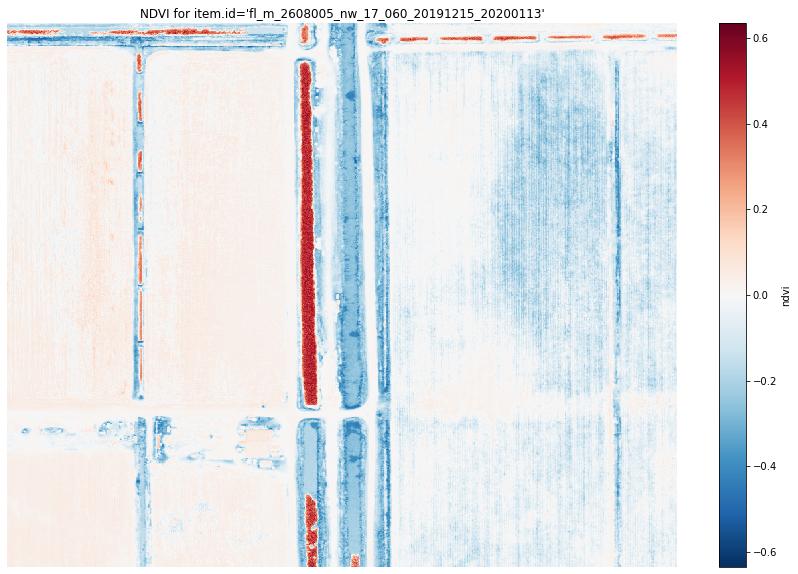

In [6]:
import matplotlib.pyplot as plt
import pystac_client
import planetary_computer
import rioxarray
import xrspatial


catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
item = catalog.get_collection("naip").get_item(
    "fl_m_2608005_nw_17_060_20191215_20200113"
)

ds = (
    rioxarray.open_rasterio(item.assets["image"].href)
    .assign_coords(band=["red", "green", "blue", "nir"])
    .load()
    .astype(float)
)

ndvi = xrspatial.ndvi(ds.sel(band="red"), ds.sel(band="nir"))

fig, ax = plt.subplots(figsize=(15, 10))
ndvi.isel(y=slice(1000), x=slice(1000)).plot.imshow(ax=ax)
ax.set_axis_off()

ax.set(title=f"NDVI for {item.id=}");

### Write to Azure Blob Storage

Now we'll use the `azure.storage.blob` Python library to write this data to blob storage.

In this case we'll write to the `pc-scratch` *container* in the `pcstoraccount` *storage account*. This is a private container so we need to somehow authorize the access to the storage account. There are [several ways](https://docs.microsoft.com/en-us/azure/storage/common/storage-auth?toc=/azure/storage/blobs/toc.json) to achieve this, but we'll use a SAS token that was generated in the Azure Portal. Make sure to include the necessary permissions for what you're trying to accomplish (including write new files, perhaps to delete existing ones).

This SAS token should be considered sensitive and kept secret. We recommend against storing secrets in plain-text on the Planetary Computer Hub. For this interactive example, we'll manually paste it into the Python session using `getpass.getpass`. If you [deploy your own Hub](https://planetarycomputer.microsoft.com/docs/concepts/hub-deployment/), you'd have additional options available, including granting access to an Azure Key Vault that could store the secrets.

In [9]:
import getpass
import azure.storage.blob

sas_token = getpass.getpass()  # prompts for the sas_token
container_client = azure.storage.blob.ContainerClient(
    "https://pcstoraccounts.blob.core.windows.net",
    container_name="pc-scratch",
    credential=sas_token,
)

 ·············································································································································


Now we're ready to write the `ndvi` data to a single-band COG and upload that to Blob Storage. We write data to an in-memory `io.BytesIO` buffer, which can be uploaded to Azure Blob Storage with `container_client.upload_blob`.

In [10]:
import io

with io.BytesIO() as buffer:
    ndvi.rio.to_raster(buffer, driver="COG")
    buffer.seek(0)
    blob_client = container_client.get_blob_client("ndvi-wb.tif")
    blob_client.upload_blob(buffer, overwrite=True)

ERROR 4: `/vsimem/59212886-9a56-4905-9ac1-eea030fa0228/59212886-9a56-4905-9ac1-eea030fa0228.tif' not recognized as a supported file format.


ServiceRequestError: <urllib3.connection.HTTPSConnection object at 0x7fb34f545490>: Failed to establish a new connection: [Errno -2] Name or service not known

Now the data is available in Azure Blob Storage, in our private storage container. To read the data, we use the same connection string, or generate a read-only [SAS token](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) and attach it to the URL of the blob. This lets tools like `rasterio` and `rioxarray` open the data without having to download it locally.

In [4]:
import urllib.parse

sas_token = azure.storage.blob.generate_blob_sas(
    container_client.account_name,
    container_client.container_name,
    blob_client.blob_name,
    account_key=container_client.credential.account_key,
    permission=["read"],
)
url = blob_client.url + "?" + urllib.parse.quote_plus(sas_token)

rioxarray.open_rasterio(url)

<xarray.DataArray (band: 1, y: 12250, x: 11050)>
[135362500 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.494e+05 5.494e+05 5.494e+05 ... 5.56e+05 5.56e+05
  * y            (y) float64 2.987e+06 2.987e+06 ... 2.979e+06 2.979e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ndvi

### Next steps

For more on Azure Blob Storage, see the [Python quickstart](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-python) and the [general introduction to Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-blobs-introduction). For more on the tools used in this example, see the documentation for [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html), [xarray](https://xarray.pydata.org/en/stable/), and [rasterio](https://rasterio.readthedocs.io/en/latest/), and [xarray-spatial](https://xarray-spatial.org/).